In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
kkk = 1

In [2]:
def g(x):
    return np.e**(-2*np.sin(2*x)) + 2*np.cos(2*x)
a = -np.pi
b = 2 * np.pi

In [3]:
def fun_painter(func, names, points = None, title=None):
    global kkk
    plt.figure()
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    for i in range(len(func)):
        x = np.linspace(a, b, 1000)
        y = func[i](x)
        plt.plot(x, y, label=names[i])
    plt.legend()
    if title is not None:
        plt.title(title)
    if points is not None:
        plt.plot(points[0], points[1], marker='o', linestyle='')
    name = "obrazek" + str(kkk) + ".png"
    plt.savefig(name,bbox_inches='tight')
    kkk+=1
    plt.show()

In [4]:
def generate_regular(a, b, f, n):
    x = np.linspace(a, b, n)
    y = f(x)
    return x, y

thousand_test_points = np.linspace(a, b, 1000) 

In [5]:
def max_diff(p, f=g, points=thousand_test_points):
    res = 0
    for i in points:
        res = max(res, abs(f(i) - p(i)))
    return res

In [6]:
def generate_chebyshev(a, b, f, n):
    x = []
    for k in range(n, 0, -1):
        x.append(.5*(a+b) + .5*(b-a)*np.cos((2*k-1)*np.pi/(2*n)))
    x = np.array(x)
    y = f(x)
    return x, y

In [7]:
def second_spline(x_data, y_data, state=0):
    #0 - natural spline
    #1 - clamped boundary

    n = len(x_data)

    def y(i):
        return (y_data[i] - y_data[i-1]) / (x_data[i]-x_data[i-1])

    c_s = []
    b_s = []
    a_s = y_data

    if state == 0:
        b_s.append(0)
    elif state == 1:
        b_s.append((y_data[1] - y_data[0]) / (x_data[1] - x_data[0]))

    for i in range(1, n):
        b_s.append(2 * y(i) - b_s[-1])

    for i in range(n - 1):
        c_s.append((b_s[i + 1] - b_s[i]) / (2 * (x_data[i + 1] - x_data[i])))

    def spline_function(x):
        y = np.zeros_like(x)
        for i in range(n - 1):
            mask = (x >= x_data[i]) & (x <= x_data[i + 1])
            difference = x[mask] - x_data[i]
            y[mask] = a_s[i] + b_s[i] * difference + c_s[i] * difference ** 2
        return y

    return spline_function

In [8]:
def sum_diff(p, f=g, points=thousand_test_points):
    res = 0
    for i in points:
        res += (f(i) - p(i)) ** 2
    return res / len(points)

In [9]:
def cubic_spline(x_data, y_data, state=0):
    #0 - cubic function
    #1 - natural spline
    #2 - clamped boundary

    n = len(x_data)

    def h(i):
        return x_data[i+1] - x_data[i]

    def delta(i):
        return (y_data[i+1] - y_data[i]) / h(i)

    def delta_2(i):
        return (delta(i+1)-delta(i)) / (x_data[i+2] - x_data[i])

    def delta_3(i):
        return (delta_2(i+1)-delta_2(i)) / (x_data[i+3] - x_data[i])

    A = np.zeros((n,n), dtype=float)
    b = np.zeros(n, dtype=float)

    for i in range(1, n-1):
        A[i,i-1:i+2] = h(i-1), 2*(h(i-1)+h(i)), h(i)
        b[i] = delta(i) - delta(i-1)
    if state == 0:
        A[0,0:2] = -h(0), h(0)
        A[-1,n-2:n] = h(n-2), -h(n-2)
        b[0] = h(0)**2 * delta_3(0)
        b[-1] =  -h(n-2)**2 * delta_3(n-4)
    elif state == 1:
        A[0,0] = 1
        A[-1,-1] = 1
        b[0] = 0
        b[-1] = 0
    elif state == 2:
        A[0,:2] = 2,1
        A[-1,n-2:n] = 2,1
        b[0] = 0
        b[-1] = 0

    sigma = np.linalg.solve(A, b.T)
    d_s = []
    c_s = []
    b_s = []
    a_s = []
    
    for i in range(n-1):
        d_s.append((sigma[i+1] - sigma[i]) /  h(i))
        c_s.append(sigma[i] * 3)
        b_s.append((y_data[i+1] - y_data[i]) / h(i) - h(i) * (sigma[i+1] + 2 * sigma[i]))
        a_s.append(y_data[i])

    def spline_function(x):
        y = np.zeros_like(x)
        for i in range(n - 1):
            mask = (x >= x_data[i]) & (x <= x_data[i + 1])
            difference = x[mask] - x_data[i]
            y[mask] = a_s[i] + b_s[i] * difference + c_s[i] * difference ** 2 + d_s[i] * difference ** 3
        return y

    return spline_function

In [10]:
def generate_summary(n):
    pr = generate_regular(a, b, g, n)
    s1 = second_spline(*pr)
    s2 = second_spline(*pr, state=1)
    fun_painter([s1,s2,g], ["Natural spline","Clamped boundary","f(x)"], pr, "Funkcja sklejana 2. stopnia")
    print("------------------------------FUNKCJA SKLEJANA 2. STOPNIA------------------------------")
    print("Maksymalna różnica natural spline: ", max_diff(s1))
    print("Błąd średni kwadratowy natural spline: ", sum_diff(s1))
    print("----------------------------------------------------------------------")
    print("Maksymalna różnica clamped boundary: ", max_diff(s2))
    print("Błąd średni kwadratowy clamped boundary: ", sum_diff(s2))
    print("----------------------------------------------------------------------")
    
    if n < 4:
        return
    pr = generate_regular(a, b, g, n)
    c1 = cubic_spline(*pr)
    c2 = cubic_spline(*pr, state=1)
    c3 = cubic_spline(*pr, state=2)
    fun_painter([c1,c2,c3,g], ["Cubic function","Natural spline","Clamped boundary","f(x)"], pr, "Funkcja sklejana 3. stopnia")
    print("------------------------------FUNKCJA SKLEJANA 3. STOPNIA------------------------------")
    print("Maksymalna różnica cubic function: ", max_diff(c1))
    print("Błąd średni kwadratowy cubic function: ", sum_diff(c1))
    print("----------------------------------------------------------------------")
    print("Maksymalna różnica natural spline: ", max_diff(c2))
    print("Błąd średni kwadratowy natural spline: ", sum_diff(c2))
    print("----------------------------------------------------------------------")
    print("Maksymalna różnica clamped boundary: ", max_diff(c3))
    print("Błąd średni kwadratowy clamped boundary: ", sum_diff(c3))
    print("----------------------------------------------------------------------")


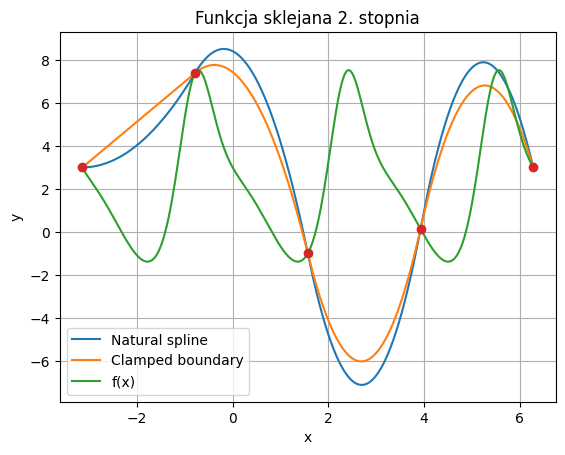

------------------------------FUNKCJA SKLEJANA 2. STOPNIA------------------------------
Maksymalna różnica natural spline:  14.334544894577931
Błąd średni kwadratowy natural spline:  34.81563214783479
----------------------------------------------------------------------
Maksymalna różnica clamped boundary:  13.302202992565025
Błąd średni kwadratowy clamped boundary:  30.107091518445483
----------------------------------------------------------------------


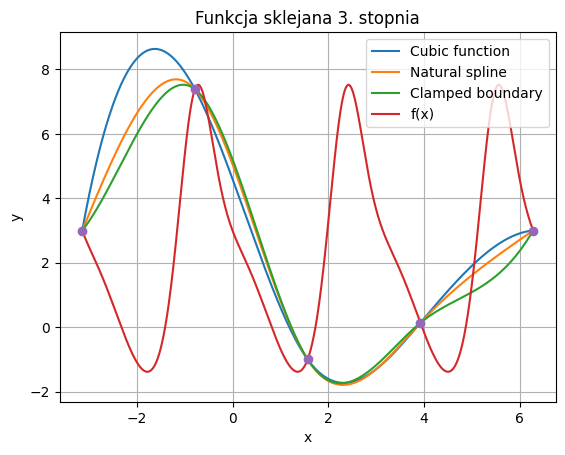

------------------------------FUNKCJA SKLEJANA 3. STOPNIA------------------------------
Maksymalna różnica cubic function:  9.983076043313151
Błąd średni kwadratowy cubic function:  21.10236363125399
----------------------------------------------------------------------
Maksymalna różnica natural spline:  9.30175695687594
Błąd średni kwadratowy natural spline:  17.858709984188437
----------------------------------------------------------------------
Maksymalna różnica clamped boundary:  9.233241712952461
Błąd średni kwadratowy clamped boundary:  16.909041303062544
----------------------------------------------------------------------


In [11]:
generate_summary(5)

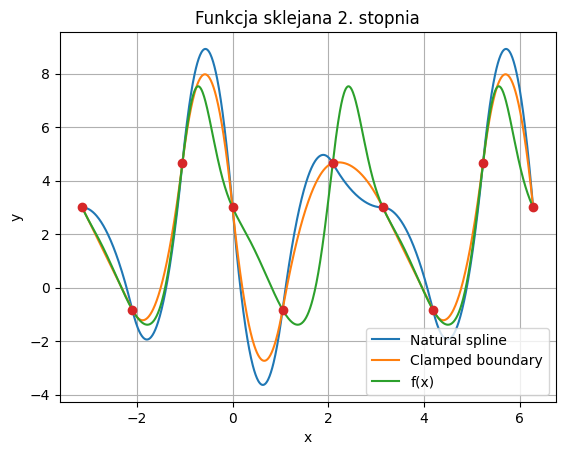

------------------------------FUNKCJA SKLEJANA 2. STOPNIA------------------------------
Maksymalna różnica natural spline:  5.127989660810031
Błąd średni kwadratowy natural spline:  4.27720951081636
----------------------------------------------------------------------
Maksymalna różnica clamped boundary:  4.176021010617911
Błąd średni kwadratowy clamped boundary:  2.4992535527364064
----------------------------------------------------------------------


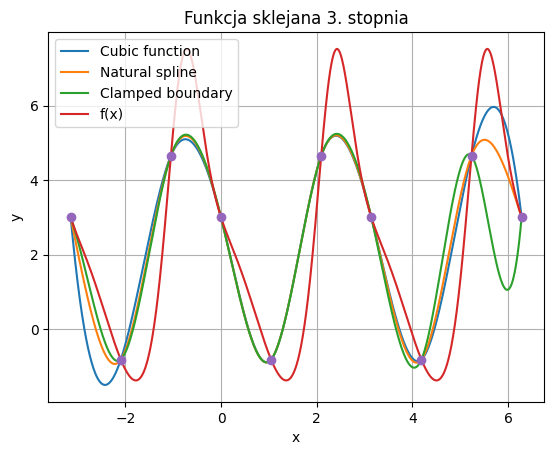

------------------------------FUNKCJA SKLEJANA 3. STOPNIA------------------------------
Maksymalna różnica cubic function:  3.1079813285366145
Błąd średni kwadratowy cubic function:  2.2524660529417577
----------------------------------------------------------------------
Maksymalna różnica natural spline:  2.8311593791027017
Błąd średni kwadratowy natural spline:  2.115785324555364
----------------------------------------------------------------------
Maksymalna różnica clamped boundary:  4.971020902917099
Błąd średni kwadratowy clamped boundary:  3.508715597210336
----------------------------------------------------------------------


In [12]:
generate_summary(10)

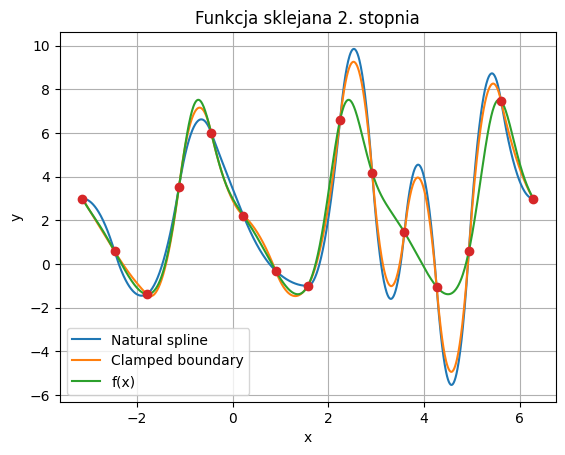

------------------------------FUNKCJA SKLEJANA 2. STOPNIA------------------------------
Maksymalna różnica natural spline:  4.324986133559379
Błąd średni kwadratowy natural spline:  2.805985296340989
----------------------------------------------------------------------
Maksymalna różnica clamped boundary:  3.7220867758649323
Błąd średni kwadratowy clamped boundary:  1.8991573290559358
----------------------------------------------------------------------


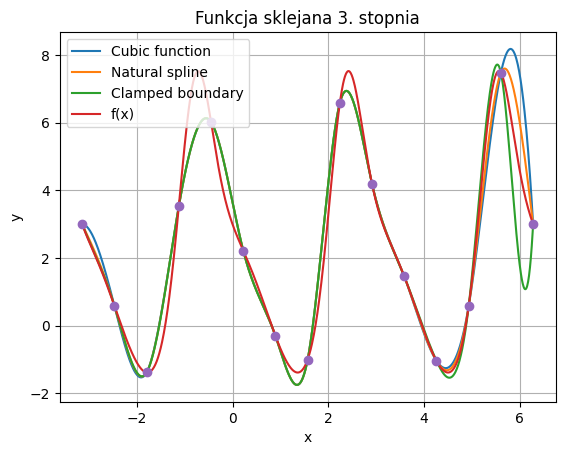

------------------------------FUNKCJA SKLEJANA 3. STOPNIA------------------------------
Maksymalna różnica cubic function:  2.8364406139068983
Błąd średni kwadratowy cubic function:  0.5689442879126848
----------------------------------------------------------------------
Maksymalna różnica natural spline:  1.7457015976091288
Błąd średni kwadratowy natural spline:  0.321074952635678
----------------------------------------------------------------------
Maksymalna różnica clamped boundary:  2.8936202976111325
Błąd średni kwadratowy clamped boundary:  0.5087973349188912
----------------------------------------------------------------------


In [13]:
generate_summary(15)

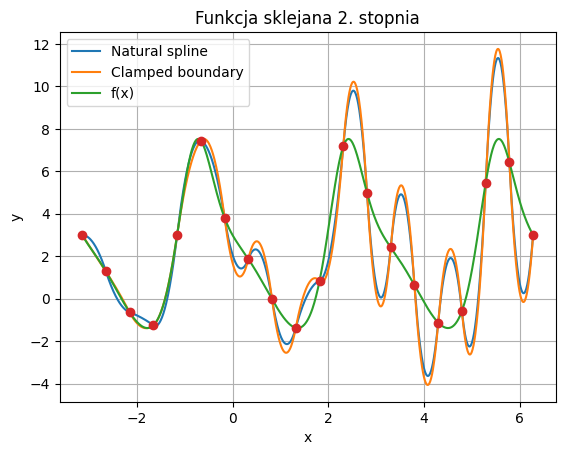

------------------------------FUNKCJA SKLEJANA 2. STOPNIA------------------------------
Maksymalna różnica natural spline:  3.9200613287116353
Błąd średni kwadratowy natural spline:  2.858034661628057
----------------------------------------------------------------------
Maksymalna różnica clamped boundary:  4.349415103586513
Błąd średni kwadratowy clamped boundary:  3.7382618618598453
----------------------------------------------------------------------


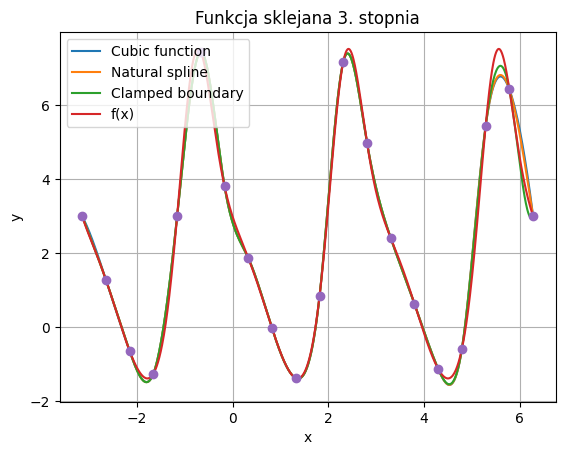

------------------------------FUNKCJA SKLEJANA 3. STOPNIA------------------------------
Maksymalna różnica cubic function:  0.77479158964079
Błąd średni kwadratowy cubic function:  0.05554694188249451
----------------------------------------------------------------------
Maksymalna różnica natural spline:  0.7325055874803548
Błąd średni kwadratowy natural spline:  0.048304261457774576
----------------------------------------------------------------------
Maksymalna różnica clamped boundary:  0.5082219221074427
Błąd średni kwadratowy clamped boundary:  0.03065166596511985
----------------------------------------------------------------------


In [14]:
generate_summary(20)

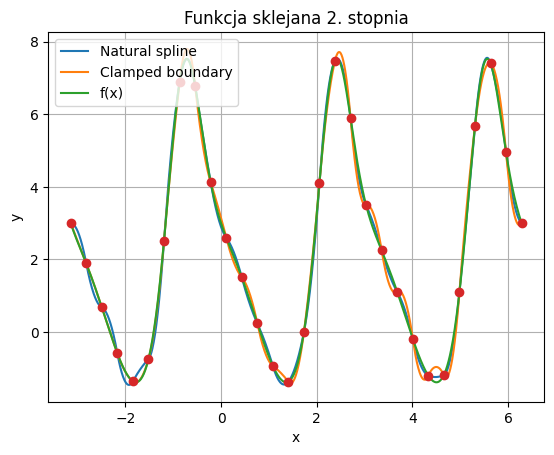

------------------------------FUNKCJA SKLEJANA 2. STOPNIA------------------------------
Maksymalna różnica natural spline:  0.32577900984153463
Błąd średni kwadratowy natural spline:  0.01725424995833126
----------------------------------------------------------------------
Maksymalna różnica clamped boundary:  0.4975259310160567
Błąd średni kwadratowy clamped boundary:  0.04280181368729739
----------------------------------------------------------------------


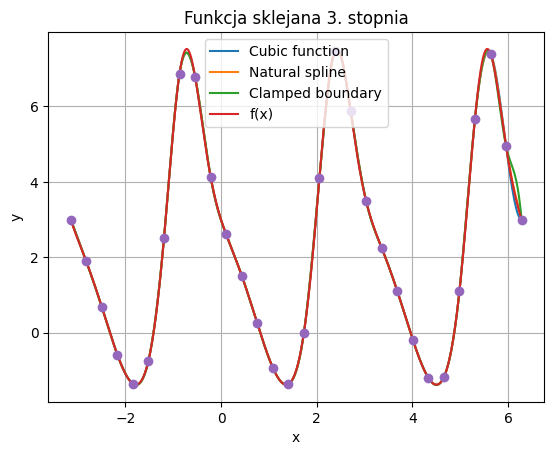

------------------------------FUNKCJA SKLEJANA 3. STOPNIA------------------------------
Maksymalna różnica cubic function:  0.2207191643532025
Błąd średni kwadratowy cubic function:  0.002030344821588474
----------------------------------------------------------------------
Maksymalna różnica natural spline:  0.11761005253441681
Błąd średni kwadratowy natural spline:  0.0009423413615543926
----------------------------------------------------------------------
Maksymalna różnica clamped boundary:  0.5229777172553556
Błąd średni kwadratowy clamped boundary:  0.005391098313717543
----------------------------------------------------------------------


In [15]:
generate_summary(30)

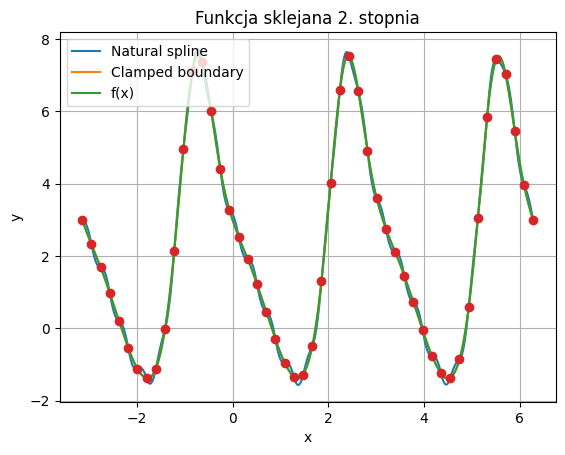

------------------------------FUNKCJA SKLEJANA 2. STOPNIA------------------------------
Maksymalna różnica natural spline:  0.20691882387666283
Błąd średni kwadratowy natural spline:  0.01826294860106171
----------------------------------------------------------------------
Maksymalna różnica clamped boundary:  0.03866456038935251
Błąd średni kwadratowy clamped boundary:  0.0001894900847401843
----------------------------------------------------------------------


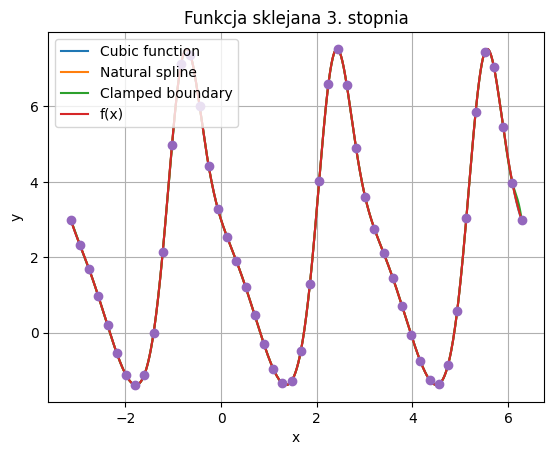

------------------------------FUNKCJA SKLEJANA 3. STOPNIA------------------------------
Maksymalna różnica cubic function:  0.028910290014262152
Błąd średni kwadratowy cubic function:  1.4072356038706349e-05
----------------------------------------------------------------------
Maksymalna różnica natural spline:  0.01444570706316739
Błąd średni kwadratowy natural spline:  8.330569817766636e-06
----------------------------------------------------------------------
Maksymalna różnica clamped boundary:  0.16275509849790915
Błąd średni kwadratowy clamped boundary:  0.0002875036663231031
----------------------------------------------------------------------


In [16]:
generate_summary(50)

In [17]:
# print("------------------------------FUNKCJA SKLEJANA 2. STOPNIA----natural spline----------------------------")
# 
# for i in range(3,101):
#     pr = generate_regular(a, b, g, i)
#     s1 = second_spline(*pr)
#     print(max_diff(s1))
#     
# print("------------------------------FUNKCJA SKLEJANA 2. STOPNIA----clamped boundary----------------------------")
# for i in range(3,101):
#     pr = generate_regular(a, b, g, i)
#     s2 = second_spline(*pr, state=1)
#     print(max_diff(s2))
#     
# print("------------------------------FUNKCJA SKLEJANA 3. STOPNIA----cubic function----------------------------")
# for i in range(4,101):
#     pr = generate_regular(a, b, g, i)
#     c1 = cubic_spline(*pr)
#     print(max_diff(c1))
# 
# print("------------------------------FUNKCJA SKLEJANA 3. STOPNIA----natural spline----------------------------")
# for i in range(4,101):
#     pr = generate_regular(a, b, g, i)
#     c2 = cubic_spline(*pr, state=1)
#     print(max_diff(c2))
#     
# print("------------------------------FUNKCJA SKLEJANA 3. STOPNIA----clamped boundary----------------------------")
# for i in range(4,101):
#     pr = generate_regular(a, b, g, i)
#     c3 = cubic_spline(*pr, state=2)
#     print(max_diff(c3))

In [17]:
generate_summary(100)